In [99]:
# !pip install numpy
# !pip install matplotlib
# Basic setup: imports and define helper functions
import asyncio, asyncssh, sys, time
import numpy as np
import matplotlib.pyplot as plt

ssh_connections = {}
%store -r

async def start_connection(hostname):
    if hostname not in ssh_connections:
        ssh_connections[hostname] = await asyncssh.connect(hostname, known_hosts=None)
    return ssh_connections[hostname]

async def run_command(hostname, command):
    conn = await start_connection(hostname)
    return (await conn.create_process(command))

async def run_command_sync(hostname, command):
    conn = await start_connection(hostname)
    result = await conn.run(command)
    return result.stdout

async def run_server(hostname):
    return (await run_command(hostname, '/mydata/localuser/frida/server/server'))

async def run_client(hostname, device_id, duration = 10, keepout = 1, datasize = 32, server="http://node0:8080", asyncOn = True):
    command_str = '/mydata/localuser/frida/experiments/throughput_bench/client {} {} {} {} {}'.format(device_id, duration,keepout,datasize,server)
    if asyncOn:
        return (await run_command(hostname, command_str))
    else:
        return (await run_command_sync(hostname, command_str))
async def run_multiple_clients(num_clients, hostname, device_id_prefix, duration = 10, keepout = 1, datasize = 32, server="http://node0:8080", asyncOn = True):
    command_str = 'cd /mydata/localuser/frida/experiments/throughput_bench && bash ./run_clients_local.sh {} {} {} {} {} {}'.format(num_clients, device_id_prefix, duration,keepout,datasize,server)
    if asyncOn:
        return (await run_command(hostname, command_str))
    else:
        return (await run_command_sync(hostname, command_str))
async def clear_server_storage(hostname):
    await run_command(hostname, "rm -r ~/storage")

async def kill_server(hostname):
    await run_command(hostname, "pkill server")
    
def parse_throughput(tstr):
    return float(tstr.split(",")[1])


In [101]:
client_task = await run_multiple_clients(20, "node1", "abcde", 10)
print((await client_task.stdout.read()).split('\n')[:-1])

['abcde_2, 86.375', 'abcde_3, 86.375', 'abcde_0, 86.5', 'abcde_5, 86.5', 'abcde_11, 86.625', 'abcde_1, 86.5', 'abcde_10, 86.625', 'abcde_7, 86.625', 'abcde_13, 86.5', 'abcde_6, 86.5', 'abcde_17, 86.625', 'abcde_18, 86.5', 'abcde_4, 86.625', 'abcde_9, 86.5', 'abcde_15, 86.5', 'abcde_8, 86.625', 'abcde_19, 86.625', 'abcde_12, 86.75', 'abcde_14, 86.625', 'abcde_16, 86.625']


In [82]:
# Run server for 10 seconds and then quit it, as a demo
server_task = await run_server("node0")
# time.sleep(10)
# server_task.terminate()

In [26]:
server_task = await run_server("node0")
client_task = await run_client("node1", "abcd")
# print(await client_task.stdout.read()) # TODO this blocks indefinitely
# time.sleep(15)
client_task.terminate()
server_task.terminate()
await run_command("node0", "rm -r ~/storage")

In [111]:
num_nodes = 2
duration = 16
keepout = 3
throughputs = []
data_size = 32
max_num_clients_per_node = 400
step_size = 50

await clear_server_storage("node0")
server_task = await run_server("node0")
for num_clients_per_node in range(50, max_num_clients_per_node + 1, step_size):
    time.sleep(5)
    ctasks = []
    num_clients = num_nodes * num_clients_per_node
#     for node in range(1, num_nodes + 1):
#         for client in range(num_clients_per_node):
#             ctask = await run_client("node{}".format(node), "exp_C{}_node{}_id{}".format(num_clients, node, client), duration, keepout, data_size)
    ctask = await run_multiple_clients(num_clients_per_node, "node{}".format(node), "exp_C{}_node{}".format(num_clients, node), duration, keepout, data_size)
    ctasks.append(ctask)
    local_throughputs = []
    time.sleep(duration)
    for ctask in ctasks:
        coutput = await ctask.stdout.read()
        for line in coutput.split("\n")[:-1]:
            if line != "":
                local_throughputs.append(parse_throughput(line))
        ctask.terminate()
        
    throughput = sum(local_throughputs)
    print("#Nodes={}, #Clients={}, Throughput = {}/s".format(num_nodes, num_clients, throughput))
    throughputs.append(throughput)
server_task.terminate()
await clear_server_storage("node0")

%store throughputs
%store num_nodes
%store keepout
%store data_size
%store max_num_clients_per_node

#Nodes=2, #Clients=100, Throughput = 4115.999999999999/s
#Nodes=2, #Clients=200, Throughput = 12449.1/s
#Nodes=2, #Clients=300, Throughput = 13778.099999999999/s
#Nodes=2, #Clients=400, Throughput = 14703.199999999993/s
#Nodes=2, #Clients=500, Throughput = 15010.800000000001/s
#Nodes=2, #Clients=600, Throughput = 15998.8/s
#Nodes=2, #Clients=700, Throughput = 15598.299999999997/s
#Nodes=2, #Clients=800, Throughput = 16840.800000000007/s
Stored 'throughputs' (list)
Stored 'num_nodes' (int)
Stored 'keepout' (int)
Stored 'data_size' (int)
Stored 'max_num_clients_per_node' (int)


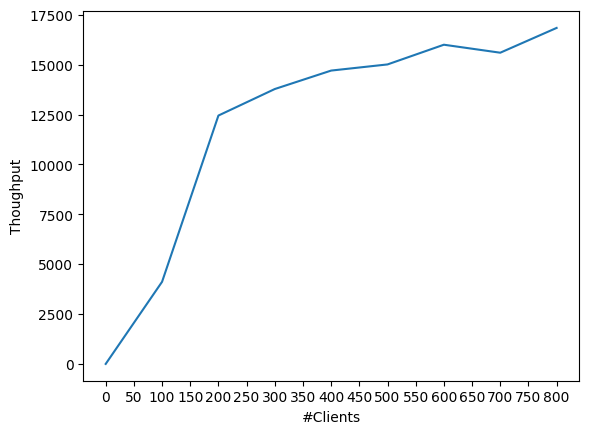

In [113]:
plt.plot([step_size*2*t for t in range(len(throughputs)+1)], [0]+throughputs)
plt.xticks(np.arange(0,max_num_clients_per_node * 2 + 1, step = step_size))
plt.xlabel("#Clients")
plt.ylabel("Thoughput")
plt.show()


In [28]:
await clear_server_storage("node0")
await kill_server("node0")